<a href="https://colab.research.google.com/github/alexlin51/GANs-Album-Covers/blob/main/Album_Cover_Fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grabbing Data from Kaggle


In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexlinn51","key":"a10a137dbd640cd45f8ce3592572034e"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d greg115/album-covers-images

100% 3.04G/3.05G [00:50<00:00, 55.2MB/s]
100% 3.05G/3.05G [00:50<00:00, 64.7MB/s]


In [ ]:
! mkdir train
! unzip album-covers-images.zip -d train

# Setting up Env  

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import style
import pandas as pd
from tqdm.auto import tqdm, trange

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [6]:
DIR = os.getcwd()

In [7]:
BATCH_SIZE = 64
EPOCHS = 10
PIXELS = 128

# Creating DataLoader

In [8]:
class ImageFolderEX(datasets.ImageFolder):
    def __getitem__(self, index):
        def get_img(index):
            path, label = self.imgs[index]
            try:
                img = self.loader(os.path.join(self.root, path))
            except:
                img = get_img(index + 1)
            return img
        img = get_img(index)
        return self.transform(img) * 2 - 1  # rescale 0 - 1 to -1 - 1

trans = transforms.Compose([
    transforms.Resize((PIXELS, PIXELS), interpolation=2), 
    transforms.ToTensor(), # implicitly normalizes the input to values between 0 - 1.
])

training_data = torch.utils.data.DataLoader(ImageFolderEX(f"{DIR}/train/", trans), 
	                                          batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0)
x = next(iter(training_data))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


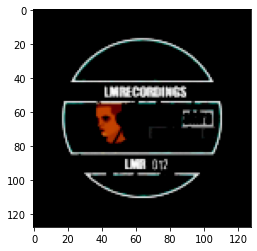

In [9]:
def Data2Img(x):
  new = torch.zeros(x.size(0), PIXELS, PIXELS, 3)
  
  for i in range(x.size(0)):
    new[i] = torch.transpose(torch.transpose(x[i], 0, 1), 1, 2)
  
  return new

plt.imshow(Data2Img(x)[2])

# Creating Generator and Discriminator Models

In [10]:
nc = 3 # Number of color channels
d_dim = 200 # Length of latent Vector (nz)

In [11]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()  

    kernel_size = 4
    padding = 1
    stride = 2
    alpha = 0.2
    size = 4 * 4 * 1024
    
    # https://www.ritchievink.com/blog/2018/07/16/generative-adversarial-networks-in-pytorch-the-distribution-of-art/
    # We take a vector of d_dim -> to length of 4 * 4 * 1024;
    # This will become a 4 x 4 image with 1024 channels, for which we insert into network
    # We blow up the image to 128 x 128 with 3 channels. 

    self.input = nn.Linear(d_dim, size)
    self.net = nn.Sequential(
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
      nn.Tanh()
    )
  
  def forward(self, z):
    x = self.input(z)
    # Note that this outputs an image with values -1 -> 1; we will 
    # need to make sure to scale to 256 after
    return self.net(x.view(-1, 1024, 4, 4))

def GenView():  
  print("Generators's Info")
  genInput = torch.randn(BATCH_SIZE, d_dim)
  print(f"Input Size: {genInput.size()}")
  testGen = Generator()
  output = testGen(genInput)
  print(f"Output Size: {output.size()}")

GenView()

Generators's Info
Input Size: torch.Size([64, 200])
Output Size: torch.Size([64, 3, 128, 128])


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        alpha = 0.2

        # Note that due to our generators outputs, we will need to make sure real
        # images are scaled properly.
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        # The net downsizes 128 x 128 by stride = 2 every layer -> 4 x 4 with 
        # 1024 channels
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        # if self.training:
        #     return x
        
        return torch.sigmoid(x)

def DiscView():
  print("Discriminator's Info")
  discInput = torch.randn(BATCH_SIZE, 3, PIXELS, PIXELS)
  print(f"Input Size: {discInput.size()}")
  testDisc = Discriminator()
  output = testDisc(discInput)
  print(f"Output Size: {output.size()}")

DiscView()

Discriminator's Info
Input Size: torch.Size([64, 3, 128, 128])
Output Size: torch.Size([64, 1])


In [ ]:
class DiscriminatorPrev(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, PIXELS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS, PIXELS * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 2, PIXELS * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 4, PIXELS * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
       return self.main(x)

class GeneratorPrev(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.main = nn.Sequential(
      nn.ConvTranspose2d(d_dim, PIXELS * 8, 4, 2, 0, bias=False),
      nn.BatchNorm2d(PIXELS * 8),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS * 8, PIXELS * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS * 4),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS * 4, PIXELS * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS * 2),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS * 2, PIXELS, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS, PIXELS, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS, nc, 4, 2, 1, bias=False),
      nn.Tanh()
  )

  def forward(self, x): 
    return self.main(x)

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    return model

D = load_checkpoint('./gdrive/My Drive/checkpointD.pth').to(device)
G = load_checkpoint('./gdrive/My Drive/checkpointG.pth').to(device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

In [24]:
print(G)
print(D)

Generator(
  (input): Linear(in_features=200, out_features=16384, bias=True)
  (net): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, 

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [25]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 

def load_optim(filepath, net, lr):
    checkpoint = torch.load(filepath)
    myOpt = optim.Adam(net.parameters(), lr = lr)
    myOpt.load_state_dict(checkpoint['optimizer'])
    return myOpt

D_optimizer = load_optim('./gdrive/My Drive/checkpointD.pth', D, lr)
G_optimizer = load_optim('./gdrive/My Drive/checkpointG.pth', G, lr)

# Training Our GANs

In [26]:
def D_train(x):
  D.zero_grad()

  # Creating inputs of real data
  realX, realY = x.to(device), torch.ones(x.size(0), 1).to(device)
  D_real_output = D(realX)
  D_real_loss = criterion(D_real_output, realY)
  
  # Creating inputs of generated data
  z = torch.randn(x.size(0),d_dim).to(device)
  fakeX, fakeY = G(z), torch.zeros(x.size(0), 1).to(device)
  D_fake_output = D(fakeX.detach())
  D_fake_output = D_fake_output.view(x.size(0), 1)
  D_fake_loss = criterion(D_fake_output, fakeY)

  
  # Take the average
  D_loss = (D_fake_loss + D_real_loss)/2
  D_loss.backward()
  D_optimizer.step()     

  # print("D ", D_loss.item())
  return D_loss.item(), x.size(0)

In [27]:
def G_train(size):
  G.zero_grad()

  # Is this consider a random distribution?
  z = torch.randn(size,d_dim).to(device)
  # We want the Discriminator to think this is all real data
  y = torch.ones(size, 1).to(device)

  G_output = G(z)
  D_output = D(G_output)
  D_output = D_output.view(size, 1)
  G_loss = criterion(D_output, y)
  
  G_loss.backward()
  G_optimizer.step()
  
  # print("G ", G_loss.item())
  return G_loss.item()

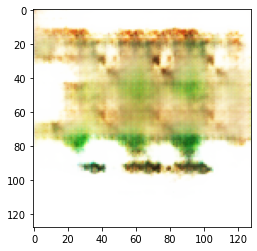

In [28]:
def view_G():
  with torch.no_grad():
    test_z = torch.randn(BATCH_SIZE,d_dim).to(device)
    generate = G(test_z)
    return (Data2Img(generate)[0] + 1) / 2

plt.imshow(view_G())

In [29]:
def save():
  path = "/content/gdrive/My Drive/" 
  checkpointG = {'model': Generator(),
              'state_dict': G.state_dict(),
              'optimizer' : G_optimizer.state_dict()}
  torch.save(checkpointG, path + 'checkpointG.pth')
  checkpointD = {'model': Discriminator(),
              'state_dict': D.state_dict(),
              'optimizer' : D_optimizer.state_dict()}
  torch.save(checkpointD, path + 'checkpointD.pth')

save()

In [30]:
def plotData(d_data, g_data):
  plt.plot(range(len(d_data)), d_data, label="Discriminator's Loss")
  plt.plot(range(len(g_data)), g_data, label="Generator's Loss")
  plt.xlabel("Training Iteration")
  plt.ylabel("Loss Values")
  plt.legend(loc='upper right')

In [31]:
generated = []
epoch_d = []
epoch_g = []

In [32]:
# 7 Checkpoints per Epoch or 11K images
# 15 Epochs Finished so far
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs Progress"):
  D_losses, G_losses = [], []
  count = 0
  for batch_idx, x in tqdm(enumerate(training_data), desc="Batch Progress"):
    if count == 200:
      count = 0
      epoch_d.append(torch.mean(torch.FloatTensor(D_losses[-200:])))
      epoch_g.append(torch.mean(torch.FloatTensor(G_losses[-200:])))
      generated.append(view_G())
      save()
    val, size = D_train(x)
    D_losses.append(val)
    G_losses.append(G_train(size)) 
    count += 1
   
  d_mean = torch.mean(torch.FloatTensor(D_losses))
  g_mean = torch.mean(torch.FloatTensor(G_losses))
  epoch_d.append(torch.mean(torch.FloatTensor(D_losses)))
  epoch_g.append(torch.mean(torch.FloatTensor(G_losses)))
  print(f"Epoch: {epoch} | D_loss: {d_mean} | G_loss: {g_mean}")
  generated.append(view_G())
  save() 
  
print(len(generated))


Epoch: 1 | D_loss: 0.03528411313891411 | G_loss: 9.534906387329102



Epoch: 2 | D_loss: 0.03867778554558754 | G_loss: 11.080377578735352



Epoch: 3 | D_loss: 0.0334845595061779 | G_loss: 11.052971839904785


KeyboardInterrupt: ignored

22


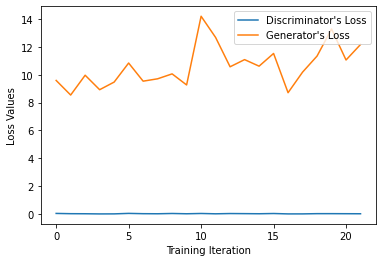

In [33]:
plotData(epoch_d, epoch_g)
print(len(generated))
save()

# Displaying Results

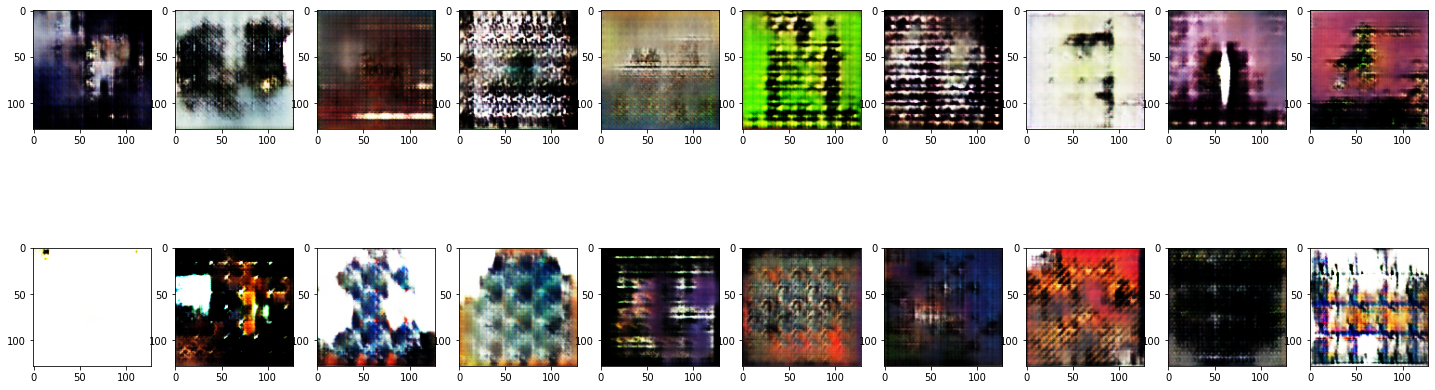

In [36]:
fig=plt.figure(figsize=(25,8))    
columns = 10  
rows = 2
for i in tqdm(range(1, columns*rows +1), desc="Drawing Generated Images"):
    fig.add_subplot(rows, columns, i)
    plt.imshow(generated[i-1].cpu())  
plt.show()

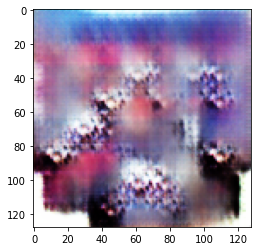

In [37]:
plt.imshow(view_G())